In [124]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from imblearn.over_sampling import SMOTE
import warnings
import time
import itertools
warnings.filterwarnings("ignore")

PCOS = pd.read_csv("PCOS.csv")

In [125]:
def confusion_matrix_train(model, cutoff=0.5):
# Confusion matrix
    cm_df = pd.DataFrame(model.pred_table(cutoff))
    #Formatting the confusion matrix
    cm_df.columns = ['Predicted 0', 'Predicted 1'] 
    cm_df = cm_df.rename(index={0: 'Actual 0',1: 'Actual 1'})
    cm = np.array(cm_df)
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    # Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    false_neg = cm[1,0]/(cm[1,0]+cm[1,1])
    false_pos = cm[0,1]/(cm[0,1]+cm[0,0])
    print("Classification accuracy = {:.4%}".format(accuracy))
    print("False Negative = {:.4%}".format(false_neg))
    print("False Positive = {:.4%}".format(false_pos))
    
def confusion_matrix_test(data,actual_values,model,cutoff=0.3):
    #Predict the values using the Logit model
    pred_values = model.predict(data)
    # Specify the bins
    bins=np.array([0,cutoff,1])
    #Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    # Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    # Return the confusion matrix and the accuracy
    false_neg = cm[1,0]/(cm[1,0]+cm[1,1])
    false_pos = cm[0,1]/(cm[0,1]+cm[0,0])
    print("Classification accuracy = {:.4%}".format(accuracy))
    print("False Negative = {:.4%}".format(false_neg))
    print("False Positive = {:.4%}".format(false_pos))

# Data Cleaning

In [126]:
PCOS = PCOS.rename(columns={"Sl. No":"num", "Patient File No.": "patient", "PCOS (Y/N)":"PCOS", "Age (yrs)": "age", 
       'Weight (Kg)' : "weight", 'Height(Cm)':"height", "Blood Group": "blood_group",'Pulse rate(bpm)': "pulse_rate",
       'RR (breaths/min)': "RR", 'Hb(g/dl)': "hb", 'Cycle(R/I)': "cycle_ri", 'Cycle length(days)': "cycle",
       'Marraige Status (Yrs)': "marriage_years", 'Pregnant(Y/N)': "pregnant", 'No. of aborptions': "number_abortions",
       '  I   beta-HCG(mIU/mL)': "I", 'II    beta-HCG(mIU/mL)': "II", 'FSH(mIU/mL)': "FAH",
       'LH(mIU/mL)': "LH", 'FSH/LH': "FSH_LH", 'Hip(inch)': "hip", 'Waist(inch)': "waist", 'Waist:Hip Ratio': "hw_ratio",
       'TSH (mIU/L)': "TSH", 'AMH(ng/mL)': "AMH", 'PRL(ng/mL)':"PRL", 'Vit D3 (ng/mL)': "vit",
       'PRG(ng/mL)':"prg", 'RBS(mg/dl)':"rbs", 'Weight gain(Y/N)':"weight_gain", 'hair growth(Y/N)':"hair_growth",
       'Skin darkening (Y/N)': "skin_dark", 'Hair loss(Y/N)': "hair_loss", 'Pimples(Y/N)': "pimples",
       'Fast food (Y/N)': "fast_food", 'Reg.Exercise(Y/N)':"regular_exercise", 'BP _Systolic (mmHg)':"bp_systolic",
       'BP _Diastolic (mmHg)': "bp_distolic", 'Follicle No. (L)':"follicle_L", 'Follicle No. (R)': "follicle_R",
       'Avg. F size (L) (mm)':"ave_size_L", 'Avg. F size (R) (mm)':"ave_size_R", 'Endometrium (mm)':"endometrium", 'Unnamed: 44':"NA"})


PCOS (Y/N): Age (C), Weight(C), pulse rate (C), RR (C), BMI (C), Years of marriage (C), Pregnant (B), Fast Food (B), Regular Exercise (B), No. of abortions (C), cycle length (c), waist/hip ratio (C), hair growth (B), pimples (B), blood group (cat)


# Modified Forward Selection: reversed SMOTE & cleaning + test on more predictors (results: better performance on Test)

In [127]:
PCOS = PCOS.drop(columns = {'NA'})
PCOS["hw_ratio"] = PCOS["hip"]/PCOS["waist"]
PCOS["height"] = PCOS["height"]/100
PCOS["BMI"] = PCOS["weight"]/np.square(PCOS["height"])
PCOS.isnull().sum()

num                 0
patient             0
PCOS                0
age                 0
weight              0
height              0
BMI                 0
blood_group         0
pulse_rate          0
RR                  0
hb                  0
cycle_ri            0
cycle               0
marriage_years      1
pregnant            0
number_abortions    0
I                   0
II                  0
FAH                 0
LH                  0
FSH_LH              0
hip                 0
waist               0
hw_ratio            0
TSH                 0
AMH                 0
PRL                 0
vit                 0
prg                 0
rbs                 0
weight_gain         0
hair_growth         0
skin_dark           0
hair_loss           0
pimples             0
fast_food           1
regular_exercise    0
bp_systolic         0
bp_distolic         0
follicle_L          0
follicle_R          0
ave_size_L          0
ave_size_R          0
endometrium         0
dtype: int64

In [128]:
PCOS = PCOS[~((PCOS['marriage_years'].isnull()) | (PCOS['fast_food'].isnull()))]
PCOS["PCOS"].value_counts()

0    363
1    176
Name: PCOS, dtype: int64

In [129]:
count_class_0, count_class_1 = PCOS.PCOS.value_counts()

# Divide by class
df_class_0 = PCOS[PCOS['PCOS'] == 0] #majority class
df_class_1 = PCOS[PCOS['PCOS'] == 1] #minority class

# Sample Majority class (y=0, to have same number of records as minority calls (y=1)
df_class_0_under = df_class_0.sample(count_class_1)
# join the dataframes containing y=1 and y=0
df_test_under = pd.concat([df_class_0_under, df_class_1])

In [130]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.PCOS.value_counts())
pcos = df_test_over
pcos.shape

Random over-sampling:
0    363
1    363
Name: PCOS, dtype: int64


(726, 44)

In [131]:
blood_group_map = {11: "A_pos", 12: "A_neg", 13: "B_pos", 14: "B_neg", 15: "O_pos", 16: "O_neg", 17: "AB_pos", 18: "AB_neg"}

pcos.loc[:, "blood_group_cat"] = pcos.loc[:, "blood_group"].map(blood_group_map)

In [132]:
np.random.seed(2)
train = pcos.sample(round(data.shape[0]*0.67))
test = pcos.drop(train.index)

In [133]:
train.columns

Index(['num', 'patient', 'PCOS', 'age', 'weight', 'height', 'BMI',
       'blood_group', 'pulse_rate', 'RR', 'hb', 'cycle_ri', 'cycle',
       'marriage_years', 'pregnant', 'number_abortions', 'I', 'II', 'FAH',
       'LH', 'FSH_LH', 'hip', 'waist', 'hw_ratio', 'TSH', 'AMH', 'PRL', 'vit',
       'prg', 'rbs', 'weight_gain', 'hair_growth', 'skin_dark', 'hair_loss',
       'pimples', 'fast_food', 'regular_exercise', 'bp_systolic',
       'bp_distolic', 'follicle_L', 'follicle_R', 'ave_size_L', 'ave_size_R',
       'endometrium', 'blood_group_cat'],
      dtype='object')

In [134]:
X = train[['age', 'weight', 'height', 'BMI', 'blood_group', 'pulse_rate', 'RR', 'hb',
           'cycle_ri', 'cycle', 'marriage_years', 'pregnant', 'number_abortions', 
           'hip', 'waist', 'hw_ratio', 'weight_gain', 
           'hair_growth', 'skin_dark', 'hair_loss',
       'pimples', 'fast_food', 'regular_exercise', 'bp_systolic',
       'bp_distolic', 'follicle_L', 'follicle_R', 'ave_size_L', 'ave_size_R',
       'endometrium']]

In [135]:
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = sm.logit('PCOS~' + '+'.join(predictor_subset), data = train).fit()
    llr = model.llr
    return {"model":model, "llr":llr}
def getBest_model(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset((list(combo))))

    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[abs(models['llr']).argmax()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return best_model
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['llr'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model
def forward_selection():
    models_best = pd.DataFrame(columns=["llr", "model"])
    
    tic = time.time()
    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [136]:
models_best = forward_selection()

Optimization terminated successfully.
         Current function value: 0.671540
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.677036
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692405
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677188
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686547
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683961
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683422
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691513
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.609919
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682880
  

Optimization terminated successfully.
         Current function value: 0.300609
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.290168
         Iterations 8
Processed  28 models on 3 predictors in 0.29277801513671875 seconds.
Optimization terminated successfully.
         Current function value: 0.242588
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.256402
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.257968
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.256514
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.257773
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.256842
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.255861
         Iterations 8
Optimization 

Optimization terminated successfully.
         Current function value: 0.185713
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.187282
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.187642
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.186326
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.186915
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.186797
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.186229
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.187654
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.187265
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.184917
  

Optimization terminated successfully.
         Current function value: 0.163387
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.164727
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.161509
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.164201
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.164035
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.162654
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.163459
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.164025
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.163791
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.163933
  

Optimization terminated successfully.
         Current function value: 0.155485
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.155538
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.155756
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.155562
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.155935
         Iterations 10
Processed  16 models on 15 predictors in 0.3161587715148926 seconds.
Optimization terminated successfully.
         Current function value: 0.153933
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.154010
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.153982
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.153664
         Iterations 10
Opti

Optimization terminated successfully.
         Current function value: 0.150007
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.149840
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.150015
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.149953
         Iterations 10
Processed  10 models on 21 predictors in 0.2437281608581543 seconds.
Optimization terminated successfully.
         Current function value: 0.149200
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.148593
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.148360
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.149276
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.149357
         Iterations 10
Opti

In [137]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["llr"])
    plt.xlabel('# Predictors')
    plt.ylabel('LLR')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

#     llr = models_best.apply(lambda row: row[1].llr, axis=1)

#     plt.subplot(2, 2, 2)
#     plt.plot(llr)
#     plt.plot(1+llr.argmax(), llr.max(), "or")
#     plt.xlabel('# Predictors')
#     plt.ylabel('adjusted LLR')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')

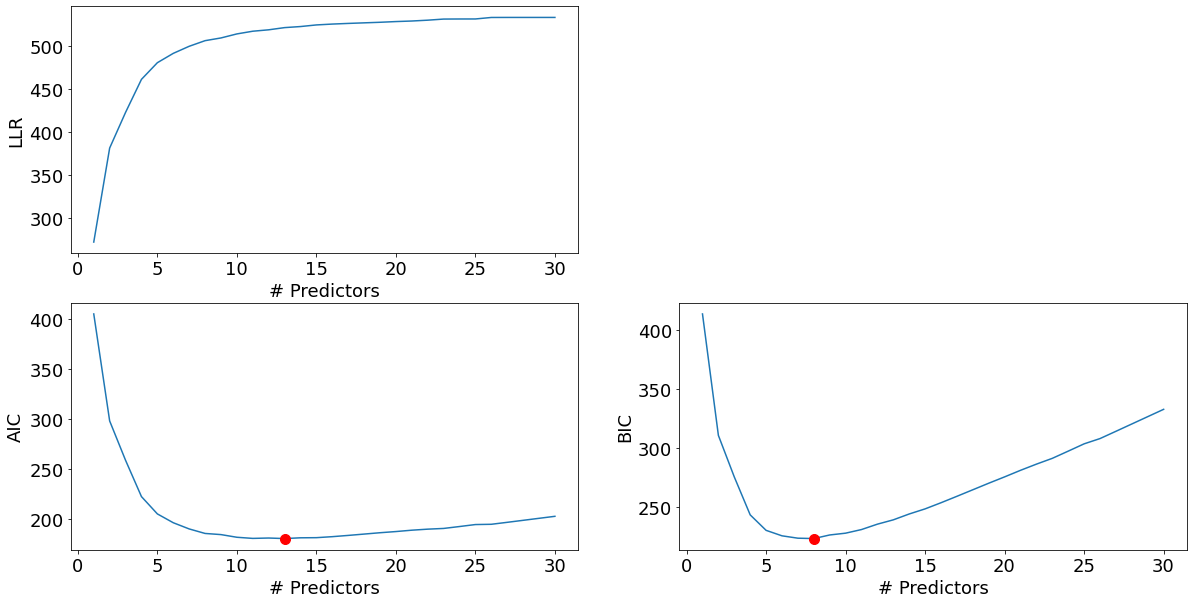

In [138]:
best_sub_plots()

In [140]:
best_interaction_model = models_best['model'][8]
best_interaction_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   PCOS   No. Observations:                  486
Model:                          Logit   Df Residuals:                      477
Method:                           MLE   Df Model:                            8
Date:                Sat, 04 Mar 2023   Pseudo R-squ.:                  0.7507
Time:                        13:06:36   Log-Likelihood:                -83.962
converged:                       True   LL-Null:                       -336.77
Covariance Type:            nonrobust   LLR p-value:                4.403e-104
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -14.0623      1.845     -7.622      0.000     -17.678     -10.446
follicle_R         0.6048      0.088      6.849      0.000       0.432       0.778
hair_growth        2.9443      0.509      5.788      0.000       1.947       3.941
cycle_ri           1.5646      0.272      5.745      0.000       1.031       2.098
skin_dark          1.9435      0.446      4.361      0.000       1.070       2.817
weight_gain        1.6777      0.435      3.853      0.000       0.824       2.531
marriage_years    -0.1263      0.046     -2.765      0.006      -0.216      -0.037
endometrium        0.2954      0.100      2.940      0.003       0.098       0.492
follicle_L         0.1749      0.071      2.464      0.014       0.036       0.314
==================================================================================
"""

Classification accuracy = 85.9155%
False Negative = 18.5185%
False Positive = 13.0435%


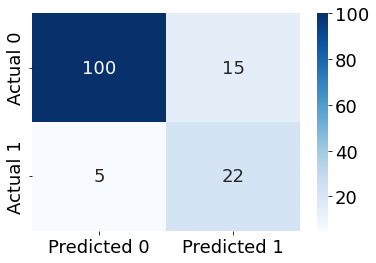

In [141]:
confusion_matrix_test(test, test.PCOS, best_interaction_model, cutoff = 0.5)

Classification accuracy = 86.6197%
False Negative = 11.1111%
False Positive = 13.9130%


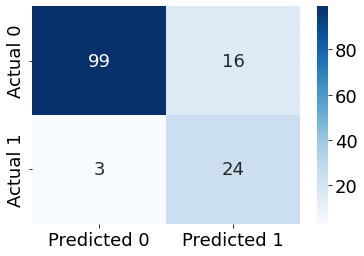

In [143]:
confusion_matrix_test(test, test.PCOS, best_interaction_model, cutoff = 0.33)

In [5]:
data = PCOS.loc[:, ["PCOS", "age", "weight", "height", "pulse_rate", "RR", "marriage_years", 'fast_food', "pregnant", "number_abortions", "hip", "waist", "regular_exercise", "cycle", "hair_growth", "pimples", "blood_group",
                   "skin_dark"]]

# Organizing data
data["hw_ratio"] = data["hip"]/data["waist"]
data["height"] = data["height"]/100
data["BMI"] = data["weight"]/np.square(data["height"])
data = data.reindex(columns=["PCOS", "age", "weight", "height", "BMI", "pulse_rate", "RR", "marriage_years", 'fast_food', "pregnant", "number_abortions", "hw_ratio", "regular_exercise", "cycle", "hair_growth", "pimples", "blood_group", "skin_dark"])
data.isnull().sum()

PCOS                0
age                 0
weight              0
height              0
BMI                 0
pulse_rate          0
RR                  0
marriage_years      1
fast_food           1
pregnant            0
number_abortions    0
hw_ratio            0
regular_exercise    0
cycle               0
hair_growth         0
pimples             0
blood_group         0
skin_dark           0
dtype: int64

In [6]:
data = data[~((data['marriage_years'].isnull()) | (data['fast_food'].isnull()))]

# Use SMOTE to generate more values

In [8]:
data["PCOS"].value_counts()

0    363
1    176
Name: PCOS, dtype: int64

In [9]:
count_class_0, count_class_1 = data.PCOS.value_counts()

# Divide by class
df_class_0 = data[data['PCOS'] == 0] #majority class
df_class_1 = data[data['PCOS'] == 1] #minority class

# Sample Majority class (y=0, to have same number of records as minority calls (y=1)
df_class_0_under = df_class_0.sample(count_class_1)
# join the dataframes containing y=1 and y=0
df_test_under = pd.concat([df_class_0_under, df_class_1])


In [10]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.PCOS.value_counts())

Random over-sampling:
0    363
1    363
Name: PCOS, dtype: int64


In [11]:
data = df_test_over
data.shape

(726, 18)

In [15]:
data = data.reindex(columns=["PCOS", "age", "weight", "height", "BMI", "pulse_rate", "RR", "marriage_years", 'fast_food', "pregnant", "number_abortions", "hw_ratio", "regular_exercise", "cycle", "hair_growth", "pimples", "blood_group", "skin_dark"])

In [16]:
data.shape

(726, 18)

### Changing Blood Group into categories

In [1082]:
blood_group_map = {11: "A_pos", 12: "A_neg", 13: "B_pos", 14: "B_neg", 15: "O_pos", 16: "O_neg", 17: "AB_pos", 18: "AB_neg"}

data.loc[:, "blood_group_cat"] = data.loc[:, "blood_group"].map(blood_group_map)
data.head()

,PCOS,age,weight,height,BMI,pulse_rate,RR,marriage_years,fast_food,pregnant,number_abortions,hw_ratio,regular_exercise,cycle,hair_growth,pimples,blood_group,skin_dark,blood_group_cat
0,0,28,44.6,1.520,19.304017,78,22,7.0,1.0,0,0,1.200000,0,5,0,0,15,0,O_pos
1,0,36,65.0,1.615,24.921163,74,20,11.0,0.0,1,0,1.187500,0,5,0,0,15,0,O_pos
3,0,37,65.0,1.480,29.674945,72,20,4.0,0.0,0,0,1.166667,0,5,0,0,13,0,B_pos
4,0,25,52.0,1.610,20.060954,72,18,1.0,0.0,1,0,1.233333,0,5,0,0,11,0,A_pos
5,0,36,74.1,1.650,27.217631,78,28,8.0,0.0,1,0,1.157895,0,5,0,0,15,0,O_pos


# VIF

In [1083]:
X = data[['age','BMI','pulse_rate','marriage_years', "fast_food", "pregnant", "number_abortions", "hw_ratio", "regular_exercise", "cycle", "hair_growth", "pimples", "skin_dark", 'blood_group']]
X.columns[1:]


Index(['BMI', 'pulse_rate', 'marriage_years', 'fast_food', 'pregnant',
       'number_abortions', 'hw_ratio', 'regular_exercise', 'cycle',
       'hair_growth', 'pimples', 'skin_dark', 'blood_group'],
      dtype='object')

In [1084]:
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)

print(vif_data)


             feature         VIF
0              const  791.638103
1                age    1.980862
2                BMI    1.138823
3         pulse_rate    1.032659
4     marriage_years    1.984835
5          fast_food    1.338369
6           pregnant    1.091864
7   number_abortions    1.128908
8           hw_ratio    1.110345
9   regular_exercise    1.126828
10             cycle    1.080745
11       hair_growth    1.328705
12           pimples    1.184357
13         skin_dark    1.299128
14       blood_group    1.059890


Since the VIF for constant is very large. All predictor VIFs are very closer to 1, indicating they do not have issues with collinearity. 

# Creating Train/Test

In [1085]:
np.random.seed(2)
train = data.sample(round(data.shape[0]*0.67))
test = data.drop(train.index)

In [1086]:
train.shape

(486, 19)

In [1087]:
test.shape

(142, 19)

# Forward Selection

In [1088]:
data.columns

Index(['PCOS', 'age', 'weight', 'height', 'BMI', 'pulse_rate', 'RR',
       'marriage_years', 'fast_food', 'pregnant', 'number_abortions',
       'hw_ratio', 'regular_exercise', 'cycle', 'hair_growth', 'pimples',
       'blood_group', 'skin_dark', 'blood_group_cat'],
      dtype='object')

In [1142]:
X = train[['age', 'weight', 'height', 'BMI', 'pulse_rate', 'RR',
       'marriage_years', 'fast_food', 'pregnant', 'number_abortions',
       'hw_ratio', 'regular_exercise', 'cycle', 'hair_growth', 'pimples',
       'skin_dark']]

In [1143]:
#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = sm.logit('PCOS~' + '+'.join(predictor_subset), data = train).fit()
    llr = model.llr
    return {"model":model, "llr":llr}


In [1144]:
#Function to select the best model amongst all models with 'k' predictors
def getBest_model(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset((list(combo))))

    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[abs(models['llr']).argmax()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return best_model

In [1145]:
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['llr'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [1146]:
def forward_selection():
    models_best = pd.DataFrame(columns=["llr", "model"])
    
    tic = time.time()
    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [1147]:
models_best = forward_selection()

Optimization terminated successfully.
         Current function value: 0.671540
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.677036
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692405
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677188
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683961
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683422
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685138
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.606404
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692886
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690931
  

Optimization terminated successfully.
         Current function value: 0.424326
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426120
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.424677
         Iterations 6
Processed  11 models on 6 predictors in 0.4152650833129883 seconds.
Optimization terminated successfully.
         Current function value: 0.413291
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411394
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412608
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409293
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412952
         Iterations 6
Optimization t

In [55]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["llr"])
    plt.xlabel('# Predictors')
    plt.ylabel('LLR')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

#     llr = models_best.apply(lambda row: row[1].llr, axis=1)

#     plt.subplot(2, 2, 2)
#     plt.plot(llr)
#     plt.plot(1+llr.argmax(), llr.max(), "or")
#     plt.xlabel('# Predictors')
#     plt.ylabel('adjusted LLR')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')

In [1154]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["llr"])
    plt.xlabel('# Predictors')
    plt.ylabel('LLR')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

#     llr = models_best.apply(lambda row: row[1].llr, axis=1)

#     plt.subplot(2, 2, 2)
#     plt.plot(llr)
#     plt.plot(1+llr.argmax(), llr.max(), "or")
#     plt.xlabel('# Predictors')
#     plt.ylabel('adjusted LLR')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')

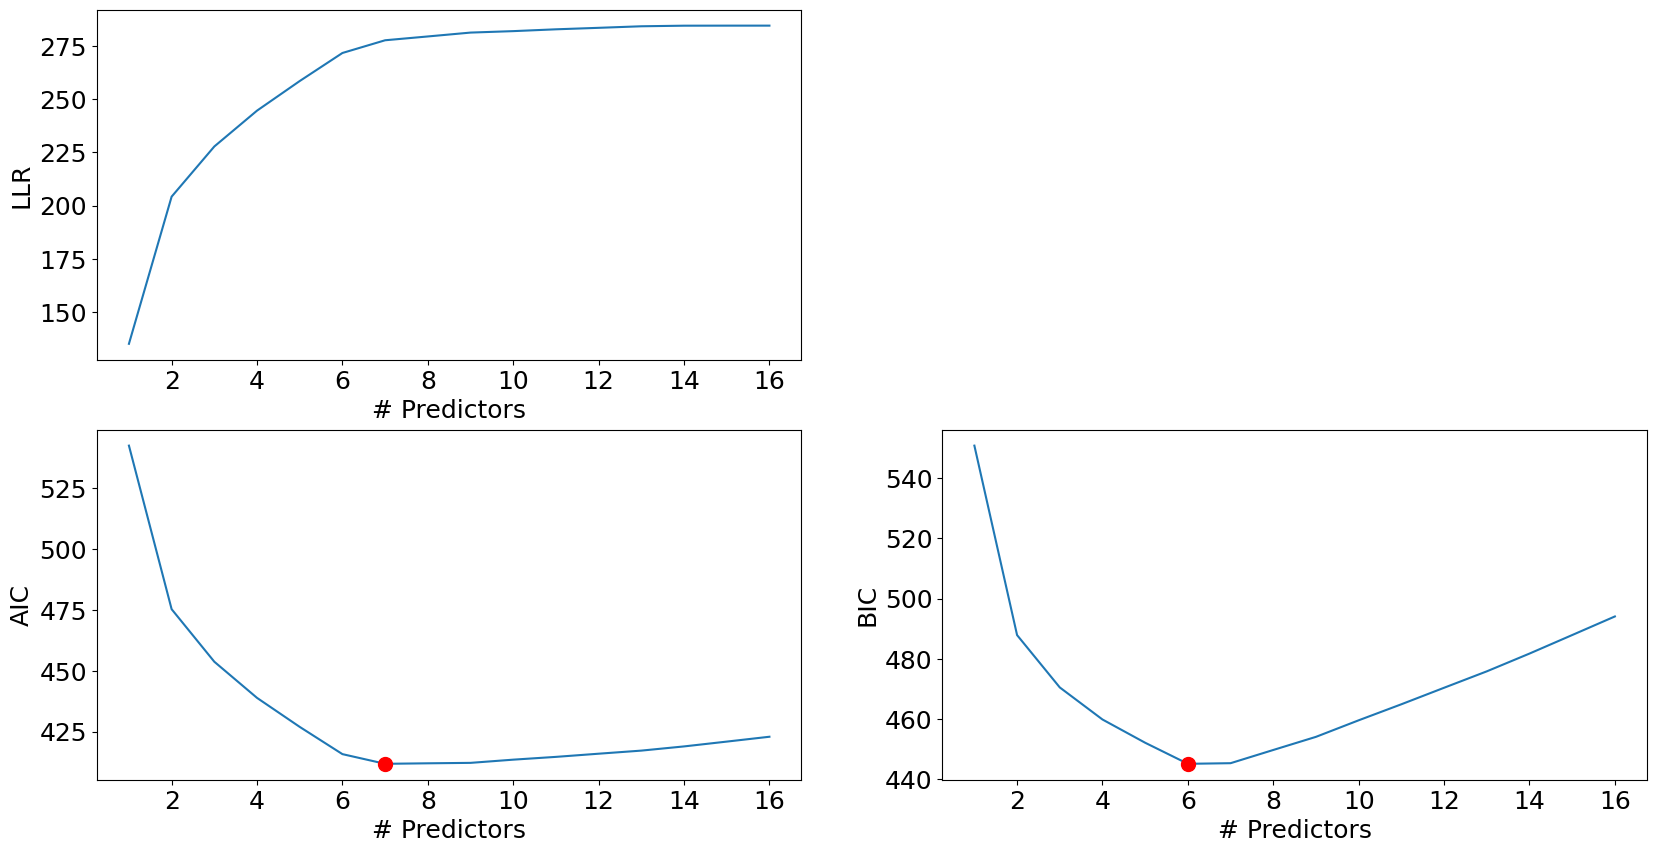

In [1155]:
best_sub_plots()

It appears that a model with 7 predictors is the best model based on the AIC criterion, and is very close to the best model based on the BIC criterion: 6 predictors.

In [1156]:
best_interaction_model = models_best['model'][7]
best_interaction_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   PCOS   No. Observations:                  486
Model:                          Logit   Df Residuals:                      478
Method:                           MLE   Df Model:                            7
Date:                Sat, 04 Mar 2023   Pseudo R-squ.:                  0.4124
Time:                        11:44:39   Log-Likelihood:                -197.89
converged:                       True   LL-Null:                       -336.77
Covariance Type:            nonrobust   LLR p-value:                 3.374e-56
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -2.0208      1.687     -1.198      0.231      -5.327       1.285
hair_growth     1.9638      0.281      6.984      0.000       1.413       2.515
skin_dark       1.7350      0.268      6.475      0.000       1.210       2.260
pimples         0.8470      0.260      3.258      0.001       0.337       1.356
cycle          -0.3191      0.081     -3.948      0.000      -0.477      -0.161
fast_food       0.9971      0.273      3.657      0.000       0.463       1.532
age            -0.0861      0.024     -3.541      0.000      -0.134      -0.038
RR              0.1918      0.079      2.434      0.015       0.037       0.346
===============================================================================
"""

Classification accuracy = 88.8889%
False Negative = 6.8966%
False Positive = 12.1739%


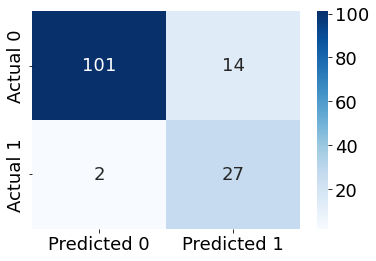

In [59]:
confusion_matrix_test(test, test.PCOS, best_interaction_model, cutoff = 0.5)

Classification accuracy = 88.1944%
False Negative = 6.8966%
False Positive = 13.0435%


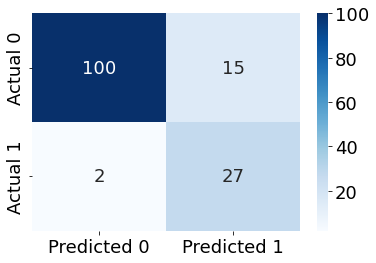

In [60]:
confusion_matrix_test(test, test.PCOS, best_interaction_model, cutoff = 0.4)

Classification accuracy = 80.2817%
False Negative = 37.0370%
False Positive = 15.6522%


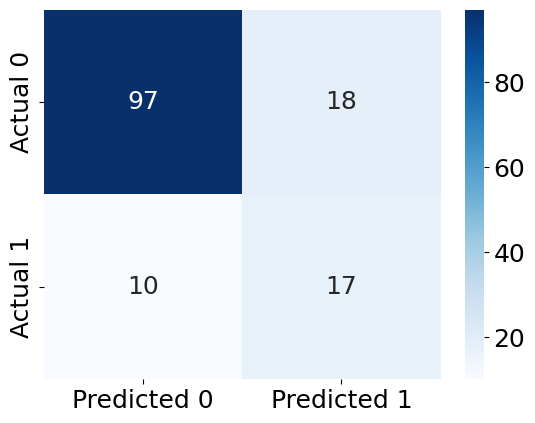

In [1157]:
confusion_matrix_test(test, test.PCOS, best_interaction_model, cutoff = 0.5)

Classification accuracy = 77.4648%
False Negative = 33.3333%
False Positive = 20.0000%


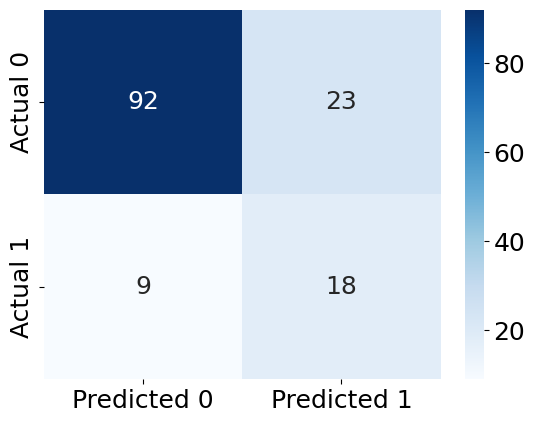

In [1159]:
confusion_matrix_test(test, test.PCOS, best_interaction_model, cutoff = 0.4)

# EDA

### Testing if age needs transformation

<AxesSubplot:xlabel='PCOS', ylabel='age'>

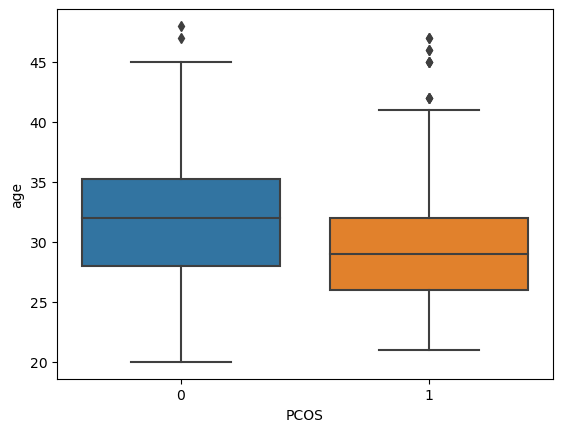

In [887]:
sns.boxplot(x = 'PCOS', y = 'age', data = train)

In [888]:
logit_model = sm.logit(formula = 'PCOS~ age', data = train).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.671540
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   PCOS   No. Observations:                  486
Model:                          Logit   Df Residuals:                      484
Method:                           MLE   Df Model:                            1
Date:                Thu, 02 Mar 2023   Pseudo R-squ.:                 0.03088
Time:                        22:10:50   Log-Likelihood:                -326.37
converged:                       True   LL-Null:                       -336.77
Covariance Type:            nonrobust   LLR p-value:                 5.108e-06
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.3934      0.558      4.287      0.000       1.299       3.488
age           -0.0790      0.018     -4.407      0.000      -0.114      -0.044
==============================================================================
"""

Classification accuracy = 56.3380%
False Negative = 51.8519%
False Positive = 41.7391%


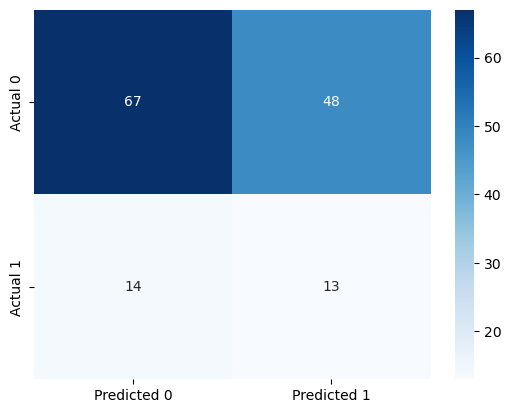

In [889]:
confusion_matrix_test(test,test.PCOS,logit_model,0.5)

In [890]:
#Binning Age
binned_age = pd.qcut(train['age'], 7, retbins=True)
train['age_binned'] = binned_age[0]

In [891]:
#Finding percentage of people having diabetes in each Age bin
age_data = train.groupby('age_binned')['PCOS'].agg([('PCOS_percent','mean'),('nobs','count')]).reset_index(drop=False)
age_data

,age_binned,PCOS_percent,nobs
0,"(19.999, 25.0]",0.671233,73
1,"(25.0, 28.0]",0.563636,110
2,"(28.0, 29.857]",0.600000,25
3,"(29.857, 31.0]",0.556962,79
4,"(31.0, 33.0]",0.354839,62
5,"(33.0, 36.0]",0.352941,68
6,"(36.0, 48.0]",0.318841,69


Text(0.5, 0, 'Age Bins')

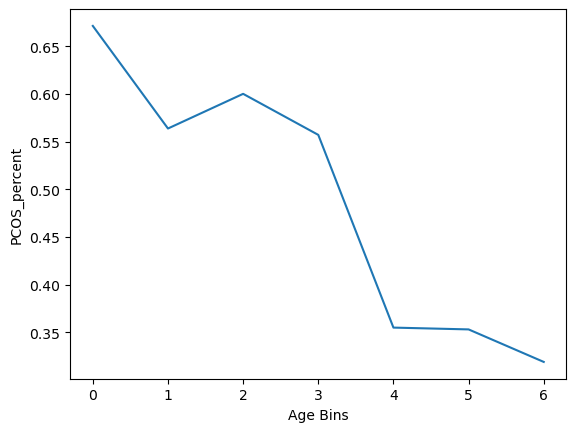

In [892]:
sns.lineplot(x = age_data.index, y = age_data['PCOS_percent'])
plt.xlabel('Age Bins')

We observe that the probability of people having PCOS does not keep decreasing monotonically with age. Try transforming using bins.

In [893]:
#Creating a function to bin age so that it can be applied to both the test and train datasets
def var_transform(data):
    binned_age = pd.qcut(train['age'],7,retbins=True)
    bins = binned_age[1]
    data['age_binned'] = pd.cut(data['age'],bins = bins)
    dum = pd.get_dummies(data.age_binned,drop_first = True)
    dum.columns = ['age'+str(x) for x in range(1,len(bins)-1)]
    data = pd.concat([data,dum], axis = 1)
    return data

In [894]:
#Binning age using the function var_transform()
train = var_transform(train)
test = var_transform(test)

Text(0.5, 0, 'Age_bin')

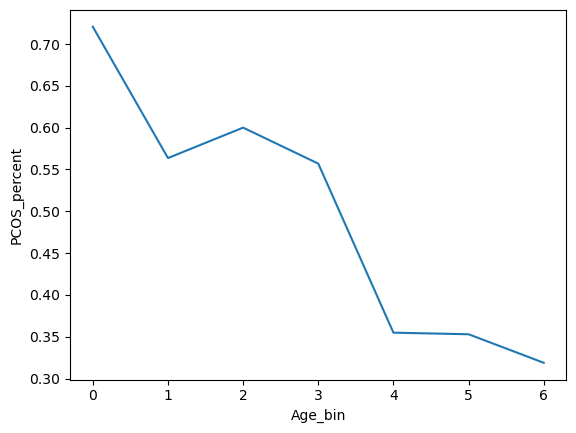

In [895]:
#Re-creating the plot of diabetes_percent vs age created earlier, just to check if the function binned age correctly. Yes, it did.
age_data = train.groupby('age_binned')['PCOS'].agg([('PCOS_percent','mean'),('nobs','count')]).reset_index(drop=False)
sns.lineplot(x = age_data.index, y= age_data['PCOS_percent'])
plt.xlabel('Age_bin')

In [896]:
# logit_model = sm.logit(formula = 'PCOS~' + '+'.join(['age'+str(x) for x in range(1,6)]), data = train).fit()
#Model with binned Age
def jitter(values,j):
    return values + np.random.normal(j,0.02,values.shape)
# sns.scatterplot(x = jitter(train.age,0), y = jitter(train.PCOS,0), data = train, color = 'orange')
logit_model = sm.logit(formula = 'PCOS~' + '+'.join(['age'+str(x) for x in range(1,7)]), data = train).fit()
# sns.lineplot(x = 'age', y= logit_model.predict(train), data = train, color = 'blue')


Optimization terminated successfully.
         Current function value: 0.659096
         Iterations 5


In [897]:
logit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   PCOS   No. Observations:                  486
Model:                          Logit   Df Residuals:                      479
Method:                           MLE   Df Model:                            6
Date:                Thu, 02 Mar 2023   Pseudo R-squ.:                 0.04883
Time:                        22:10:51   Log-Likelihood:                -320.32
converged:                       True   LL-Null:                       -336.77
Covariance Type:            nonrobust   LLR p-value:                 1.100e-05
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7138      0.249      2.865      0.004       0.225       1.202
age1          -0.4578      0.315     -1.455      0.146      -1.075       0.159
age2          -0.3083      0.478     -0.645      0.519      -1.246       0.629
age3          -0.4849      0.337     -1.440      0.150      -1.145       0.175
age4          -1.3116      0.364     -3.603      0.000      -2.025      -0.598
age5          -1.3199      0.356     -3.712      0.000      -2.017      -0.623
age6          -1.4729      0.359     -4.104      0.000      -2.176      -0.769
==============================================================================
"""

Classification accuracy = 53.5211%
False Negative = 51.8519%
False Positive = 45.2174%


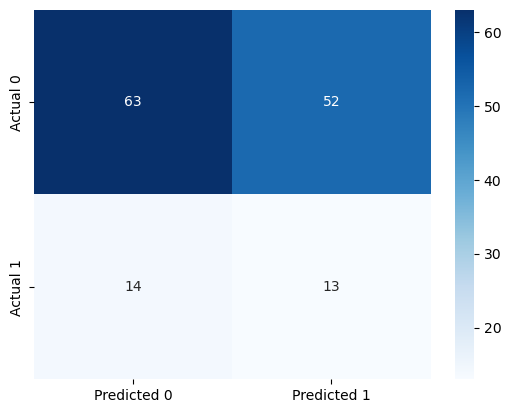

In [898]:
confusion_matrix_test(test,test.PCOS,logit_model,0.5)

Accuracy decreased, FNR stayed the same. Don't include tranformation of age.

### Testing if BMI needs transformation

<AxesSubplot:xlabel='PCOS', ylabel='BMI'>

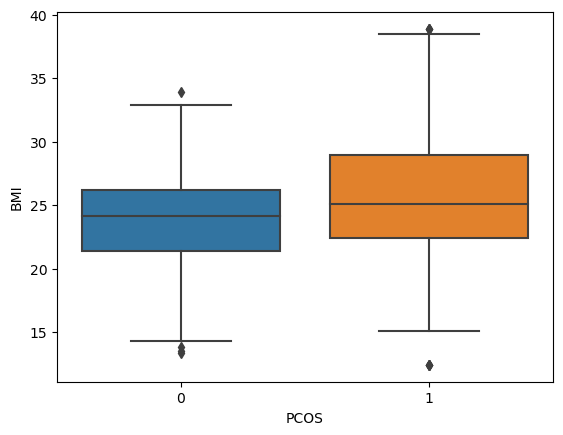

In [899]:
sns.boxplot(x = 'PCOS', y = 'BMI', data = train)

In [900]:
logit_model = sm.logit(formula = 'PCOS~BMI', data = train).fit()

Optimization terminated successfully.
         Current function value: 0.677188
         Iterations 4


Classification accuracy = 69.0141%
False Negative = 33.3333%
False Positive = 30.4348%


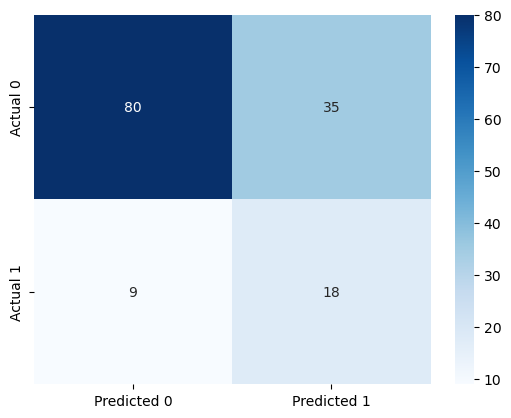

In [901]:
confusion_matrix_test(test, test.PCOS, logit_model, cutoff = 0.5)

In [902]:
#Binning weight
binned_BMI = pd.qcut(train['BMI'], 7, retbins=True)
train['BMI_binned'] = binned_BMI[0]

In [903]:
#Finding percentage of people having diabetes in each Age bin
BMI_data = train.groupby('BMI_binned')['PCOS'].agg([('PCOS_percent','mean'),('nobs','count')]).reset_index(drop=False)
BMI_data

,BMI_binned,PCOS_percent,nobs
0,"(12.417, 20.29]",0.428571,70
1,"(20.29, 22.308]",0.371429,70
2,"(22.308, 23.738]",0.529412,68
3,"(23.738, 25.236]",0.424658,73
4,"(25.236, 26.795]",0.409091,66
5,"(26.795, 29.115]",0.536232,69
6,"(29.115, 38.901]",0.728571,70


Text(0.5, 0, 'BMI_bin')

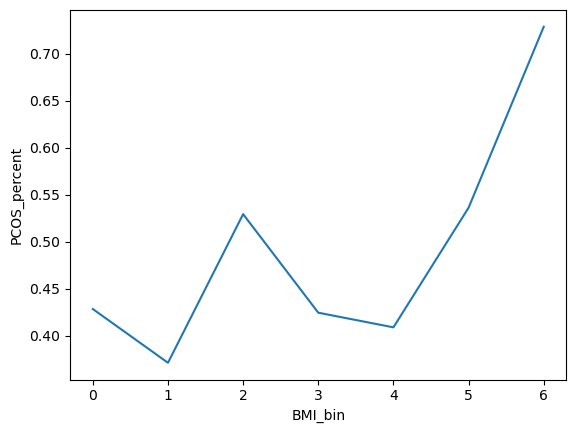

In [904]:
sns.lineplot(x = BMI_data.index, y = BMI_data['PCOS_percent'])
plt.xlabel('BMI_bin')

In [905]:
#Creating a function to bin age so that it can be applied to both the test and train datasets
def var_transform(data):
    binned_BMI = pd.qcut(train['BMI'], 7,retbins=True)
    bins = binned_BMI[1]
    data['BMI_binned'] = pd.cut(data['BMI'],bins = bins)
    dum = pd.get_dummies(data.BMI_binned,drop_first = True)
    dum.columns = ['BMI'+str(x) for x in range(1,len(bins)-1)]
    data = pd.concat([data,dum], axis = 1)
    return data

In [906]:
#Binning age using the function var_transform()
train = var_transform(train)
test = var_transform(test)

Text(0.5, 0, 'BMI_bin')

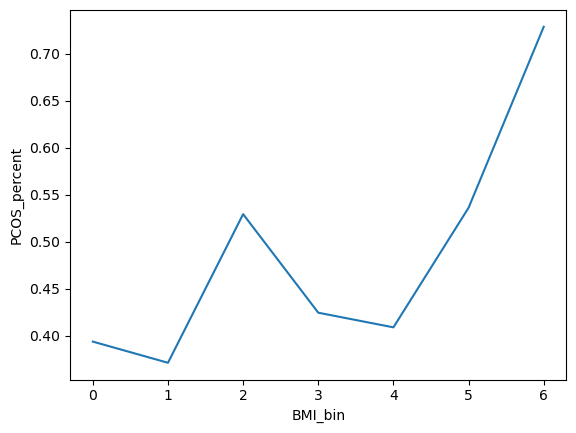

In [907]:
#Re-creating the plot of diabetes_percent vs age created earlier, just to check if the function binned age correctly. Yes, it did.
BMI_data = train.groupby('BMI_binned')['PCOS'].agg([('PCOS_percent','mean'),('nobs','count')]).reset_index(drop=False)
sns.lineplot(x = BMI_data.index, y= BMI_data['PCOS_percent'])
plt.xlabel('BMI_bin')

In [908]:
#Model with binned BMI
def jitter(values,j):
    return values + np.random.normal(j,0.02,values.shape)
# sns.scatterplot(x = jitter(train.BMI,0), y = jitter(train.PCOS,0), data = train, color = 'orange')
logit_model = sm.logit(formula = 'PCOS~' + '+'.join(['BMI'+str(x) for x in range(1,7)]), data = train).fit()
# sns.lineplot(x = 'BMI', y= model2.predict(train), data = train, color = 'blue') 



Optimization terminated successfully.
         Current function value: 0.666649
         Iterations 5


Classification accuracy = 60.5634%
False Negative = 55.5556%
False Positive = 35.6522%


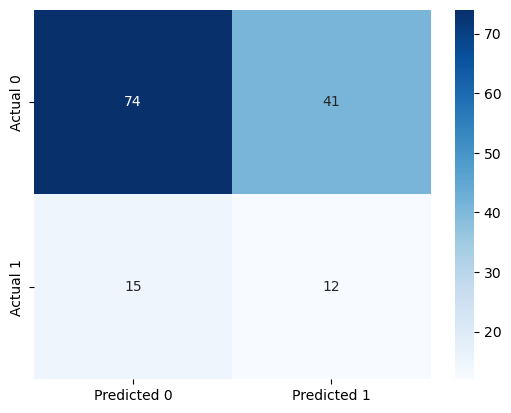

In [909]:
confusion_matrix_test(test, test.PCOS, logit_model, cutoff = 0.5)

Accuracy decreased, FNR increased by a lot. Don't include transformation of BMI.

#### Testing if hw_ratio needs tranformation

<AxesSubplot:xlabel='PCOS', ylabel='hw_ratio'>

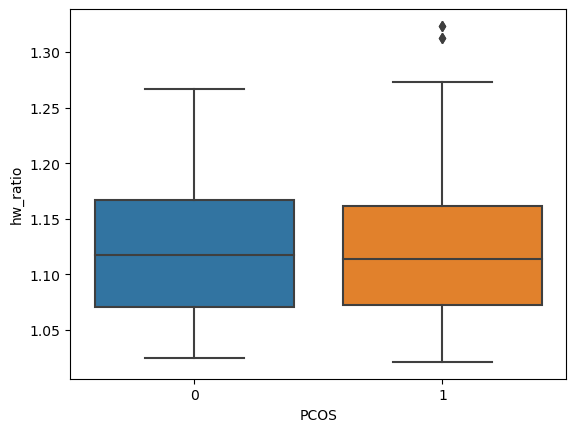

In [910]:
sns.boxplot(x = 'PCOS', y = 'hw_ratio', data = train)

In [911]:
logit_model = sm.logit(formula = 'PCOS~hw_ratio', data = train).fit()

Optimization terminated successfully.
         Current function value: 0.692819
         Iterations 3


Classification accuracy = 75.3521%
False Negative = 88.8889%
False Positive = 9.5652%


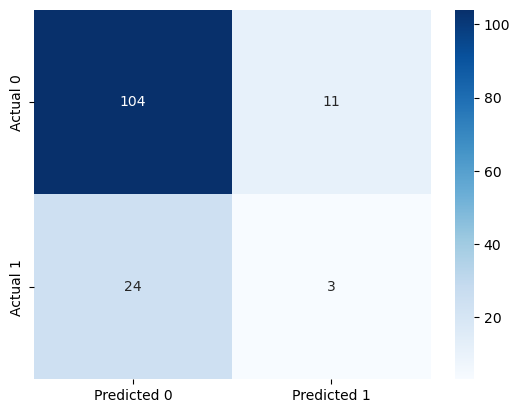

In [912]:
confusion_matrix_test(test, test.PCOS, logit_model, cutoff = 0.5)

In [913]:
#Binning hw_ratio
binned_hw = pd.qcut(train['hw_ratio'], 7, retbins=True)
train['hw_binned'] = binned_hw[0]

In [914]:
#Finding percentage of people having diabetes in each Age bin
hw_data = train.groupby('hw_binned')['PCOS'].agg([('PCOS_percent','mean'),('nobs','count')]).reset_index(drop=False)
hw_data

,hw_binned,PCOS_percent,nobs
0,"(1.02, 1.059]",0.529412,85
1,"(1.059, 1.082]",0.425926,54
2,"(1.082, 1.105]",0.536585,82
3,"(1.105, 1.125]",0.394366,71
4,"(1.125, 1.158]",0.571429,63
5,"(1.158, 1.188]",0.460317,63
6,"(1.188, 1.324]",0.485294,68


Text(0.5, 0, 'hw_bin')

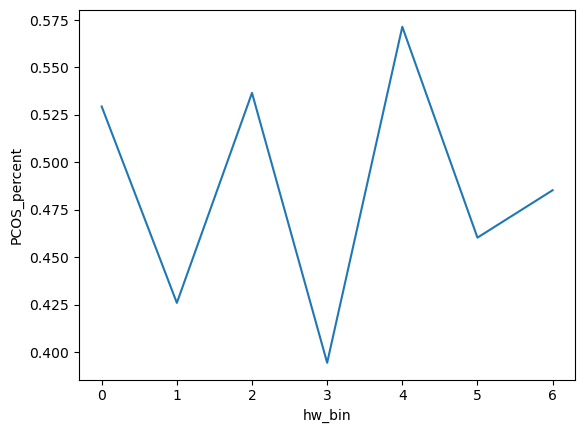

In [915]:

sns.lineplot(x = hw_data.index, y = hw_data['PCOS_percent'])
plt.xlabel('hw_bin')

In [916]:
#Creating a function to bin age so that it can be applied to both the test and train datasets
def var_transform(data):
    binned_BMI = pd.qcut(train['hw_ratio'], 7,retbins=True)
    bins = binned_BMI[1]
    data['hw_binned'] = pd.cut(data['hw_ratio'],bins = bins)
    dum = pd.get_dummies(data.hw_binned,drop_first = True)
    dum.columns = ['hw_ratio'+str(x) for x in range(1,len(bins)-1)]
    data = pd.concat([data,dum], axis = 1)
    return data

In [917]:
#Binning age using the function var_transform()
train = var_transform(train)
test = var_transform(test)

Text(0.5, 0, 'hw_bin')

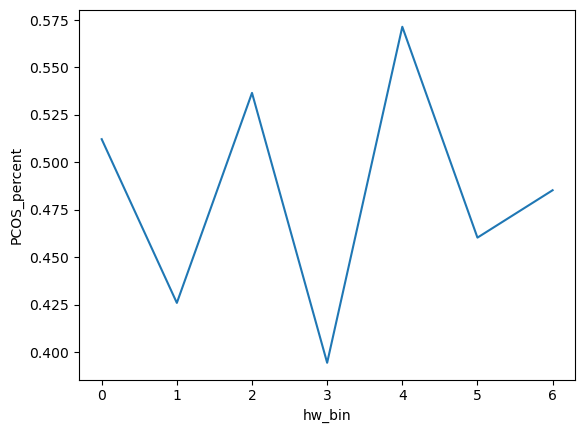

In [918]:
#Re-creating the plot of diabetes_percent vs age created earlier, just to check if the function binned age correctly. Yes, it did.
hw_data = train.groupby('hw_binned')['PCOS'].agg([('PCOS_percent','mean'),('nobs','count')]).reset_index(drop=False)
sns.lineplot(x = hw_data.index, y= hw_data['PCOS_percent'])
plt.xlabel('hw_bin')

In [919]:
#Model with binned BMI
def jitter(values,j):
    return values + np.random.normal(j,0.02,values.shape)
# sns.scatterplot(x = jitter(train.BMI,0), y = jitter(train.PCOS,0), data = train, color = 'orange')
logit_model = sm.logit(formula = 'PCOS~' + '+'.join(['hw_ratio'+str(x) for x in range(1,7)]), data = train).fit()
# sns.lineplot(x = 'BMI', y= model2.predict(train), data = train, color = 'blue') 



Optimization terminated successfully.
         Current function value: 0.686087
         Iterations 4


Classification accuracy = 55.6338%
False Negative = 62.9630%
False Positive = 40.0000%


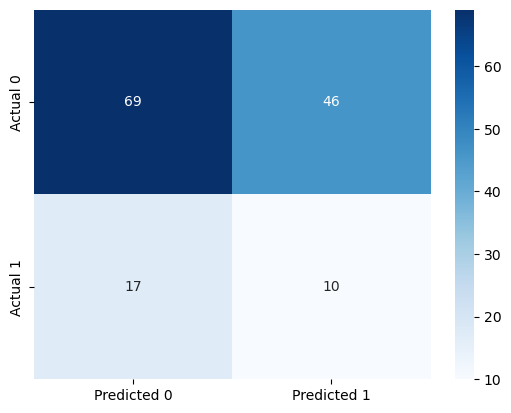

In [920]:
confusion_matrix_test(test, test.PCOS, logit_model, cutoff = 0.5)

Accuracy decreased but FNR also decreased. Might conisder adding transformation of hw_ratio.

# Testing Interactions

#### Testing Age

In [921]:
data["age"].describe()

count    726.000000
mean      31.009642
std        5.428270
min       20.000000
25%       27.000000
50%       30.000000
75%       35.000000
max       48.000000
Name: age, dtype: float64

In [922]:
sub_age = data[data.age > 31]

<AxesSubplot:xlabel='PCOS', ylabel='BMI'>

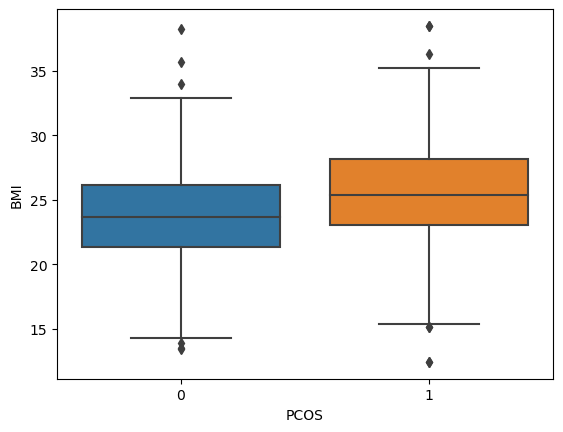

In [134]:
sns.boxplot(x = "PCOS", y = "BMI", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='BMI'>

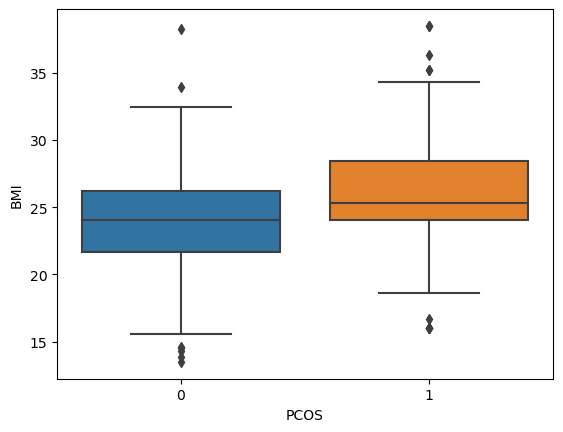

In [135]:
sns.boxplot(x = "PCOS", y = "BMI", data = sub_age)

<AxesSubplot:xlabel='PCOS', ylabel='marriage_years'>

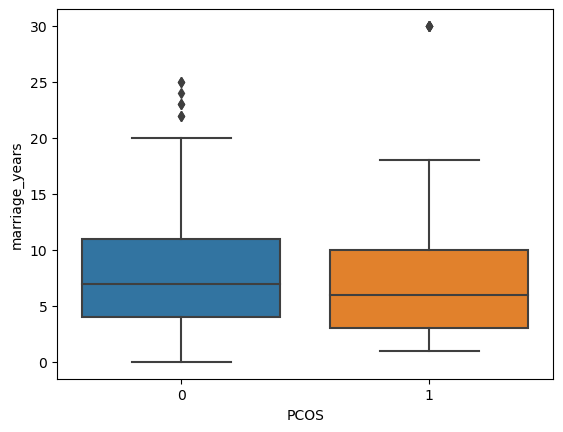

In [136]:
sns.boxplot(x = "PCOS", y = "marriage_years", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='marriage_years'>

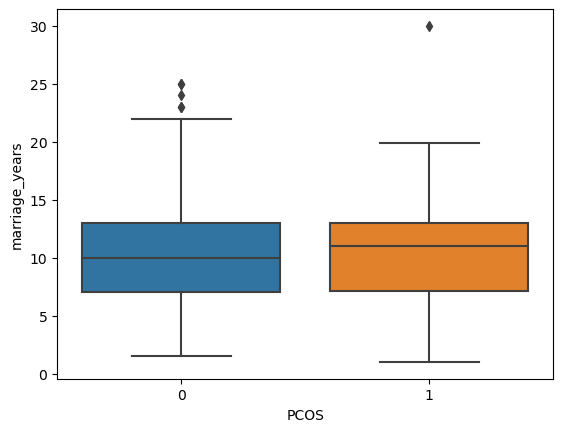

In [1906]:
sns.boxplot(x = "PCOS", y = "marriage_years", data = sub_age)

<AxesSubplot:xlabel='PCOS', ylabel='hair_growth'>

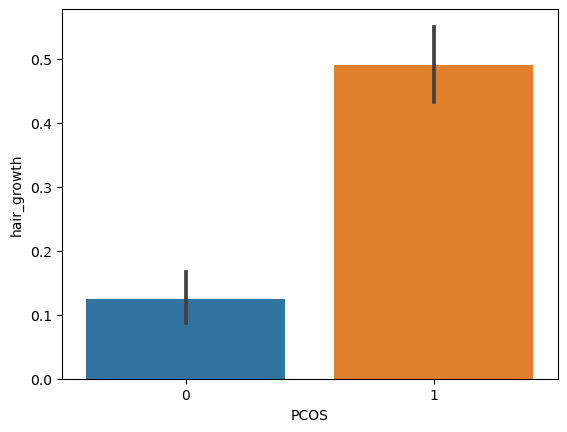

In [1907]:
sns.barplot(x = "PCOS", y = "hair_growth", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='hair_growth'>

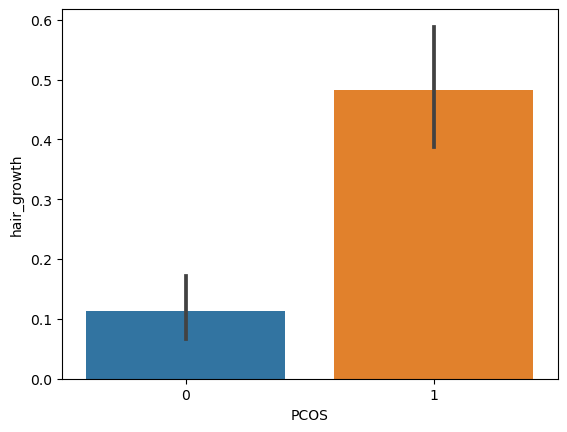

In [1908]:
sns.barplot(x = "PCOS", y = "hair_growth", data = sub_age)

Consider adding age*hair_growth

<AxesSubplot:xlabel='PCOS', ylabel='pimples'>

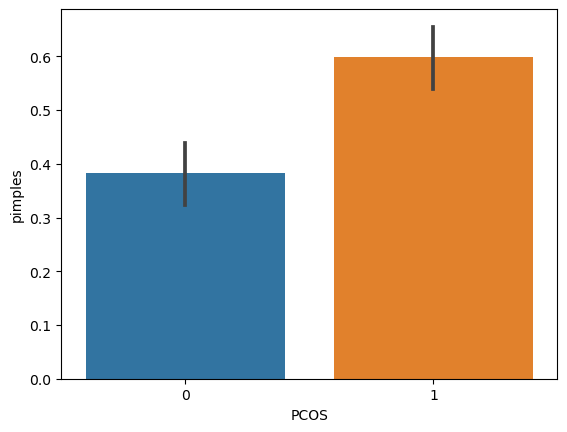

In [1909]:
sns.barplot(x = "PCOS", y = "pimples", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='pimples'>

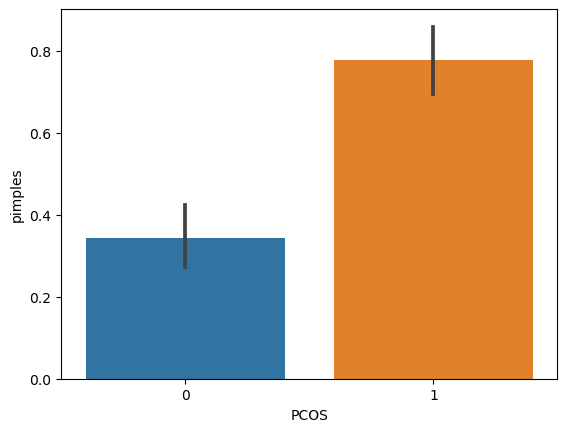

In [1910]:
sns.barplot(x = "PCOS", y = "pimples", data = sub_age)

<AxesSubplot:xlabel='PCOS', ylabel='blood_group_cat'>

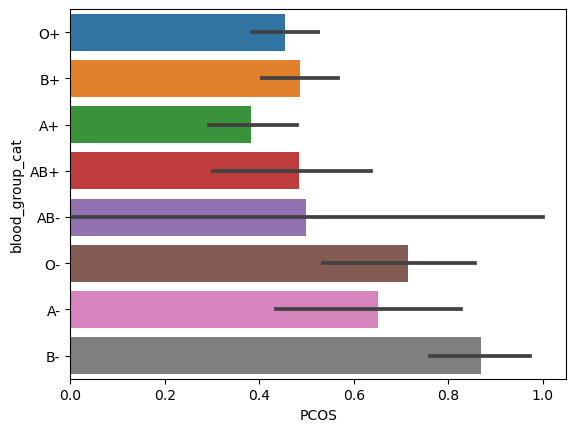

In [1911]:
sns.barplot(x = "PCOS", y = "blood_group_cat", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='blood_group_cat'>

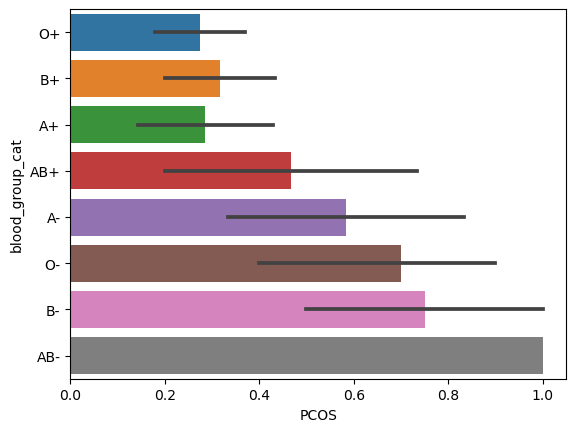

In [1912]:
sns.barplot(x = "PCOS", y = "blood_group_cat", data = sub_age)

Consider adding blood_group_cat*age

<AxesSubplot:xlabel='PCOS', ylabel='regular_exercise'>

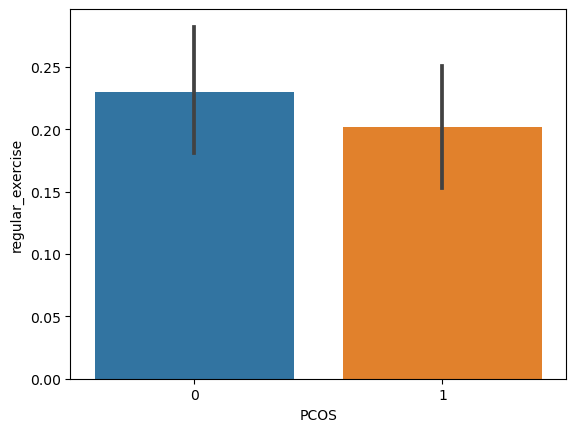

In [1913]:
sns.barplot(x = "PCOS", y = "regular_exercise", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='regular_exercise'>

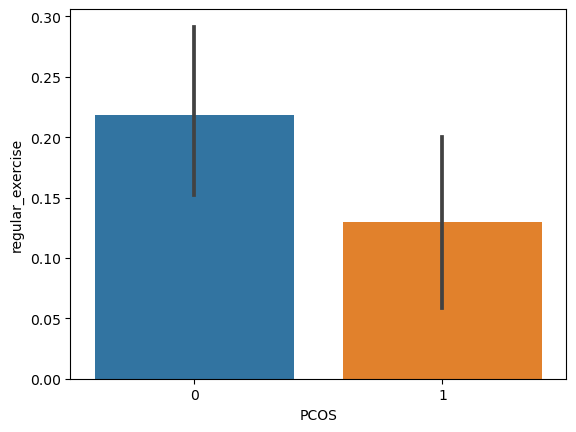

In [1914]:
sns.barplot(x = "PCOS", y = "regular_exercise", data = sub_age)

<AxesSubplot:xlabel='PCOS', ylabel='cycle'>

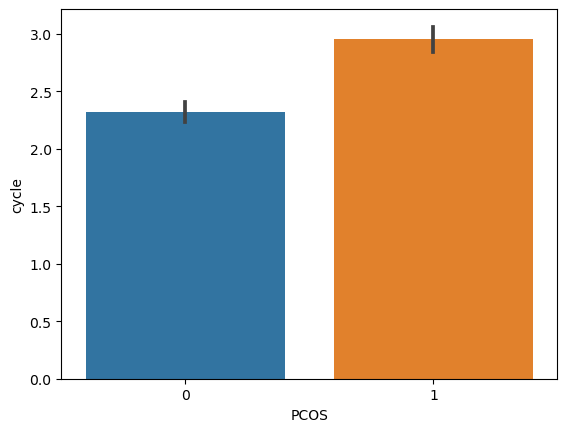

In [1915]:
sns.barplot(x = "PCOS", y = "cycle", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='cycle'>

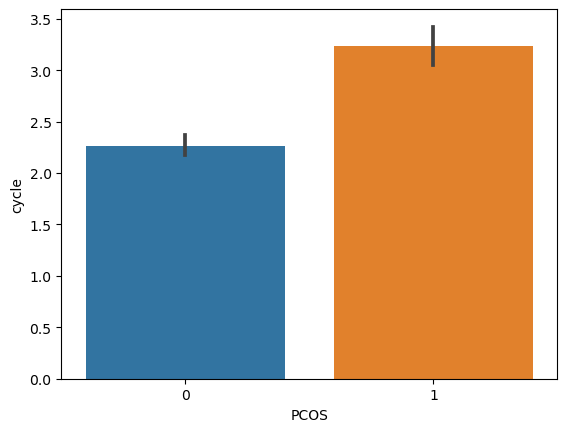

In [1916]:
sns.barplot(x = "PCOS", y = "cycle", data = sub_age)

#### Test on BMI

In [1917]:
data["BMI"].describe()

count    574.000000
mean      24.645334
std        4.175663
min       12.417882
25%       22.140197
50%       24.462387
75%       27.171620
max       38.900714
Name: BMI, dtype: float64

In [1918]:
sub_bmi = data[data.BMI > 24]

In [1962]:
sub_bmi_neg = data[data.BMI <= 24]

<AxesSubplot:xlabel='PCOS', ylabel='age'>

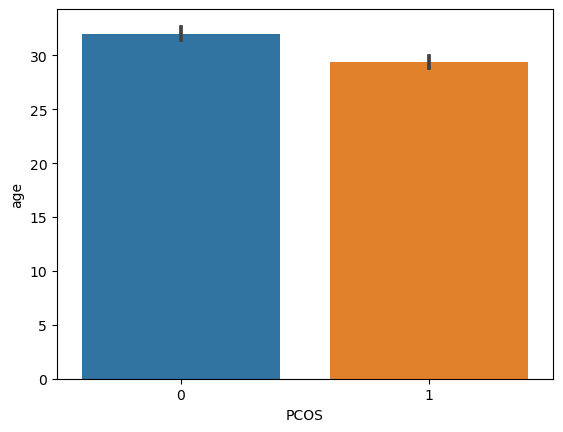

In [1960]:
sns.barplot(x = "PCOS", y = "age", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='age'>

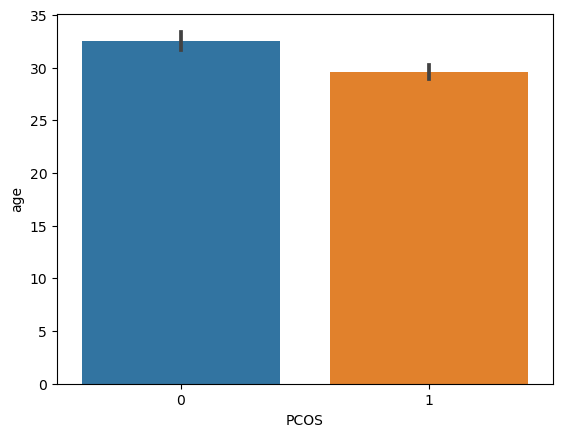

In [1961]:
sns.barplot(x = "PCOS", y = "age", data = sub_bmi)

<AxesSubplot:xlabel='PCOS', ylabel='pregnant'>

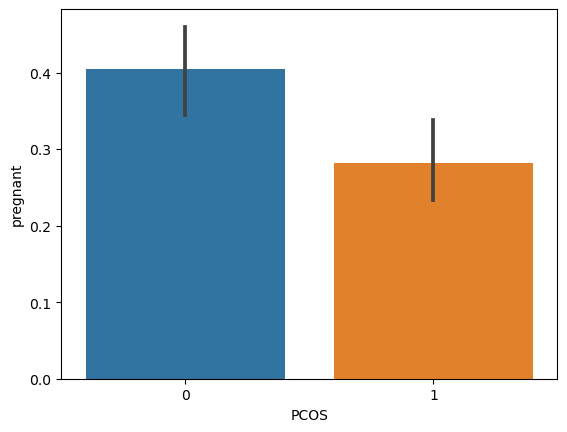

In [1919]:
sns.barplot(x = "PCOS", y = "pregnant", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='pregnant'>

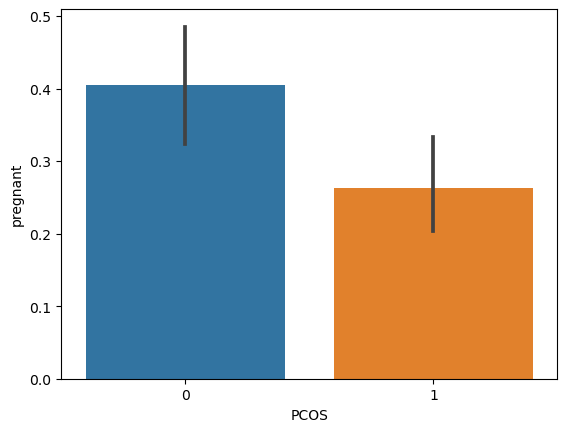

In [1920]:
sns.barplot(x = "PCOS", y = "pregnant", data = sub_bmi)

<AxesSubplot:xlabel='PCOS', ylabel='hair_growth'>

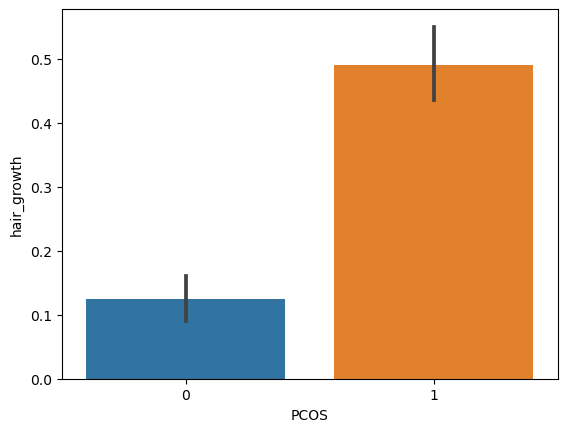

In [1921]:
sns.barplot(x = "PCOS", y = "hair_growth", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='hair_growth'>

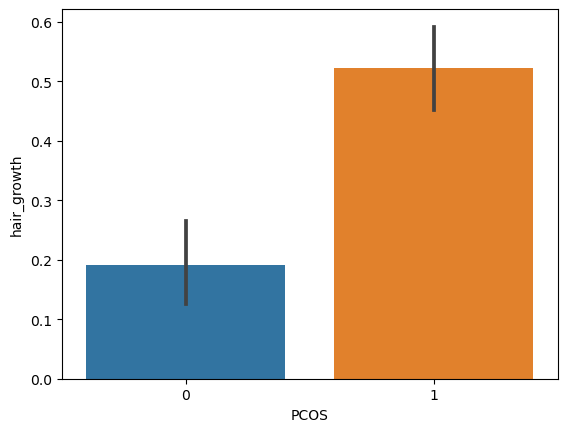

In [1922]:
sns.barplot(x = "PCOS", y = "hair_growth", data = sub_bmi)

<AxesSubplot:xlabel='PCOS', ylabel='regular_exercise'>

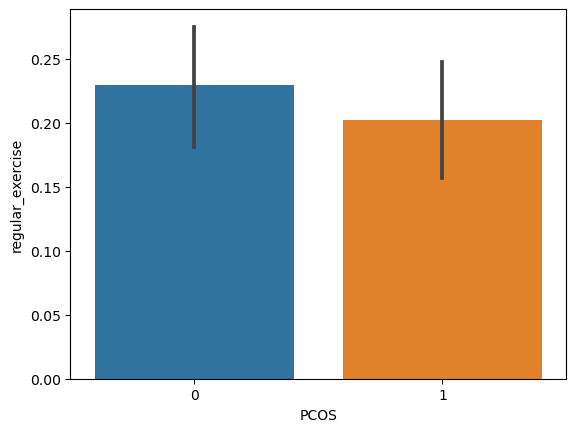

In [1983]:
sns.barplot(x = "PCOS", y = "regular_exercise", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='regular_exercise'>

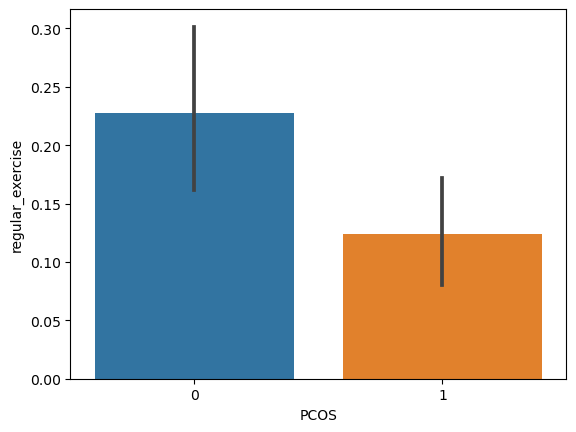

In [1984]:
sns.barplot(x = "PCOS", y = "regular_exercise", data = sub_bmi)

Consider adding BMI*regular_exercise

<AxesSubplot:xlabel='PCOS', ylabel='pimples'>

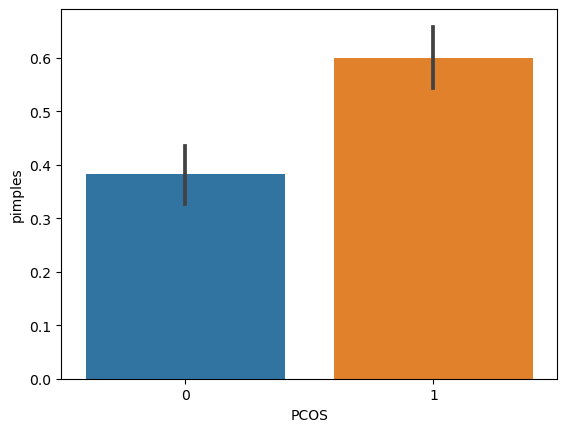

In [1925]:
sns.barplot(x = "PCOS", y = "pimples", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='pimples'>

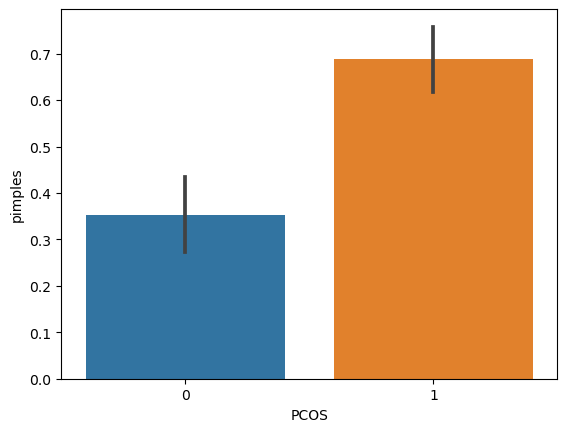

In [1926]:
sns.barplot(x = "PCOS", y = "pimples", data = sub_bmi)

Consider adding BMI*pimples

<AxesSubplot:xlabel='PCOS', ylabel='blood_group_cat'>

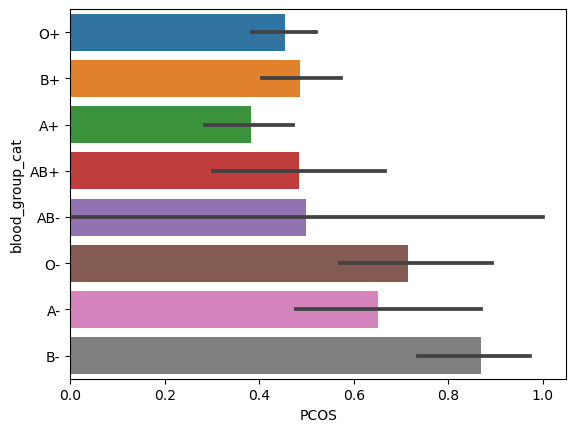

In [1927]:
sns.barplot(x = "PCOS", y = "blood_group_cat", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='blood_group_cat'>

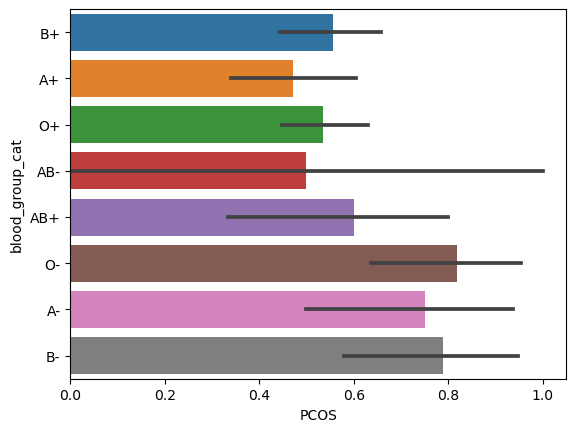

In [1928]:
sns.barplot(x = "PCOS", y = "blood_group_cat", data = sub_bmi)

Consider adding blood_group_cat*BMI

<AxesSubplot:xlabel='PCOS', ylabel='cycle'>

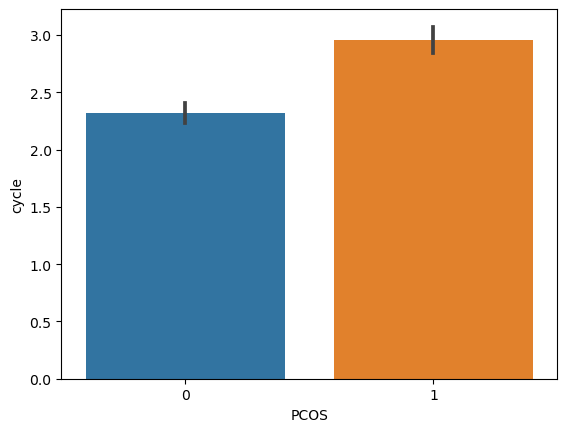

In [1929]:
sns.barplot(x = "PCOS", y = "cycle", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='cycle'>

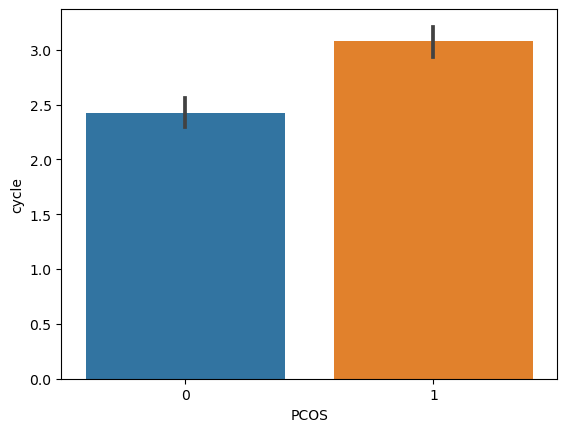

In [1930]:
sns.barplot(x = "PCOS", y = "cycle", data = sub_bmi)

#### Testing hw_ratio

In [1931]:
data["hw_ratio"].describe()

count    574.000000
mean       1.126008
std        0.058091
min        1.021277
25%        1.082736
50%        1.117647
75%        1.166667
max        1.323529
Name: hw_ratio, dtype: float64

In [1932]:
sub_hw = data[data.hw_ratio > 1.124]

<AxesSubplot:xlabel='PCOS', ylabel='fast_food'>

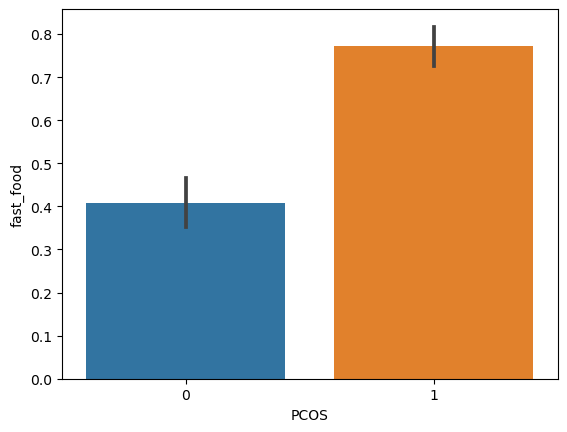

In [1933]:
sns.barplot(x = "PCOS", y = "fast_food", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='fast_food'>

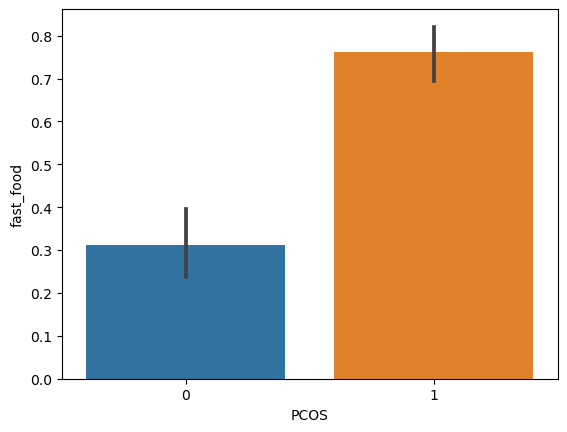

In [1934]:
sns.barplot(x = "PCOS", y = "fast_food", data = sub_hw)

Consider adding hw_ratio*fast_food

#### Testing regular exercise

In [1935]:
data["regular_exercise"].describe()

count    574.000000
mean       0.216028
std        0.411892
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: regular_exercise, dtype: float64

In [1936]:
sub_reg = data[data.regular_exercise > 0.225862]

<AxesSubplot:xlabel='PCOS', ylabel='cycle'>

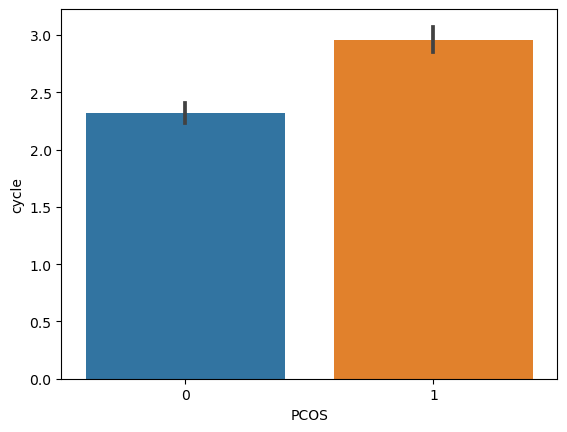

In [1937]:
sns.barplot(x = "PCOS", y = "cycle", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='cycle'>

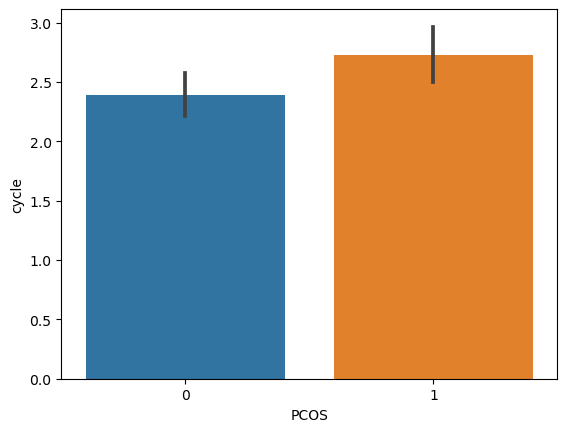

In [1938]:
sns.barplot(x = "PCOS", y = "cycle", data = sub_reg)

<AxesSubplot:xlabel='PCOS', ylabel='fast_food'>

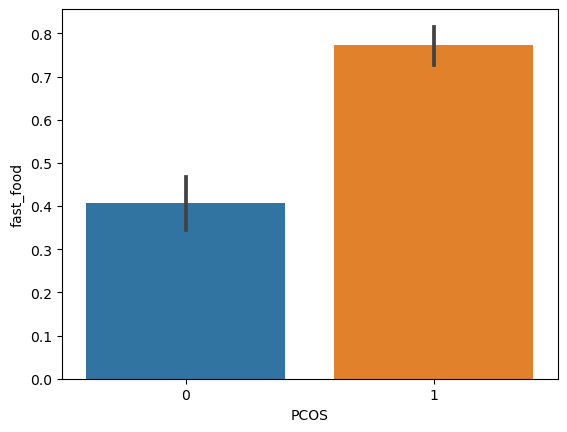

In [1939]:
sns.barplot(x = "PCOS", y = "fast_food", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='fast_food'>

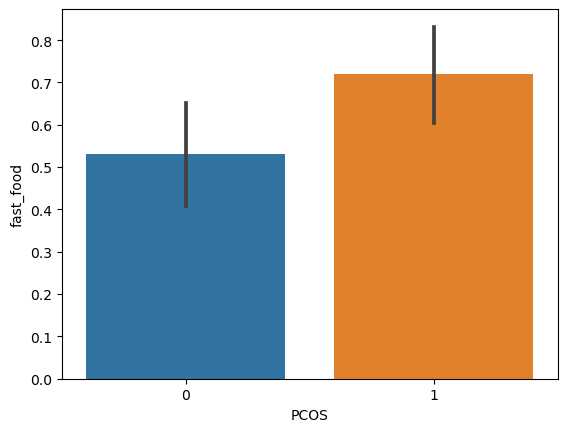

In [1940]:
sns.barplot(x = "PCOS", y = "fast_food", data = sub_reg)

Consider adding fast_food*regular_exercise

#### Testing pregnant

In [1941]:
data["pregnant"].describe()

count    574.000000
mean       0.343206
std        0.475194
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: pregnant, dtype: float64

In [1942]:
sub_preg = data[data.pregnant > 0.327]

<AxesSubplot:xlabel='PCOS', ylabel='pimples'>

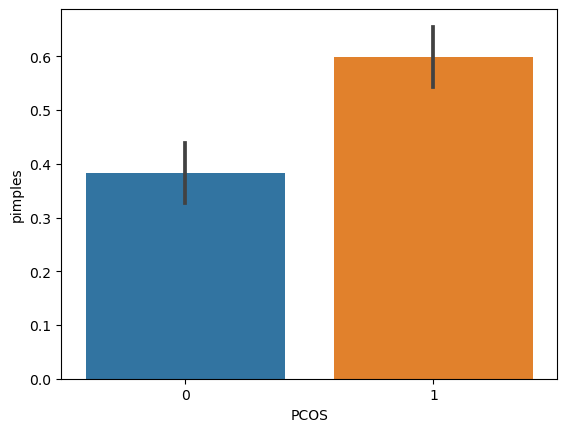

In [1943]:
sns.barplot(x = "PCOS", y = "pimples", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='pimples'>

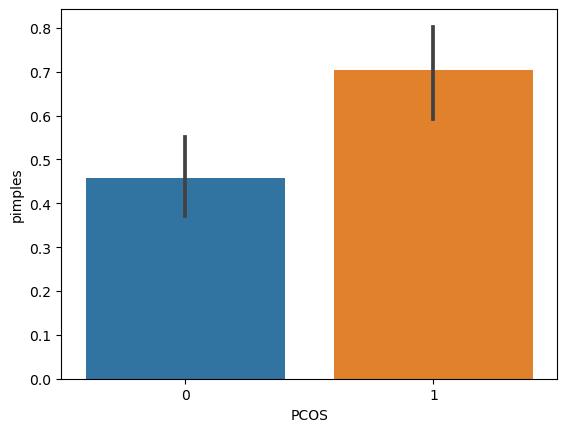

In [1944]:
sns.barplot(x = "PCOS", y = "pimples", data = sub_preg)

Consider adding pimples*pregnant

<AxesSubplot:xlabel='PCOS', ylabel='BMI'>

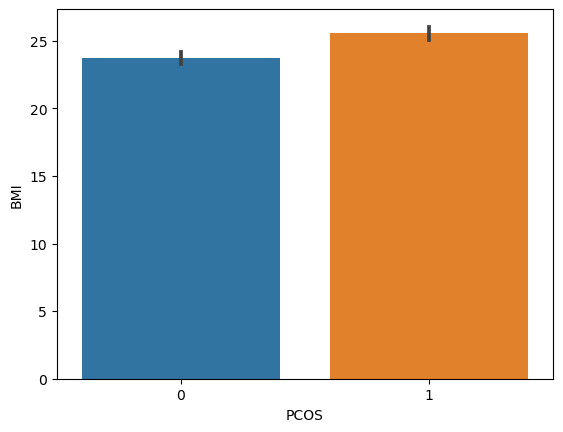

In [1945]:
sns.barplot(x = "PCOS", y = "BMI", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='BMI'>

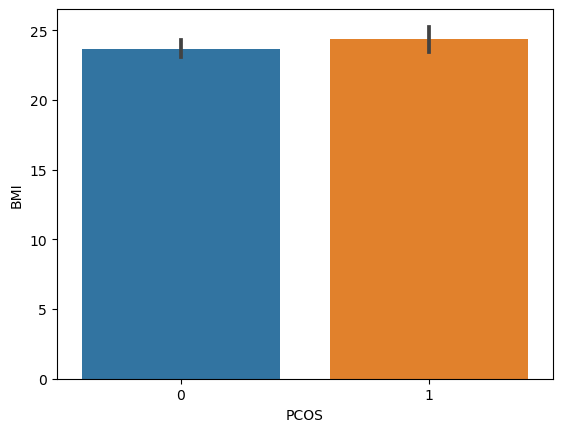

In [1946]:
sns.barplot(x = "PCOS", y = "BMI", data = sub_preg)

#### Testing pulse_rate 

In [1947]:
data["pulse_rate"].describe()

count    574.000000
mean      73.153310
std        4.258347
min       13.000000
25%       72.000000
50%       72.000000
75%       74.000000
max       82.000000
Name: pulse_rate, dtype: float64

In [1948]:
sub_pulse = data[data.pulse_rate > 73]

<AxesSubplot:xlabel='PCOS', ylabel='blood_group_cat'>

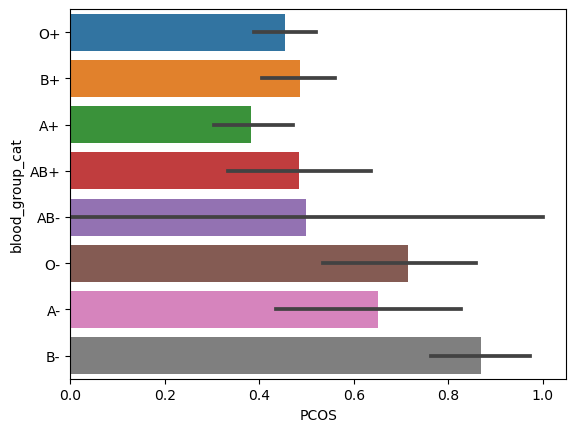

In [1949]:
sns.barplot(x = "PCOS", y = "blood_group_cat", data = data)

<AxesSubplot:xlabel='PCOS', ylabel='blood_group_cat'>

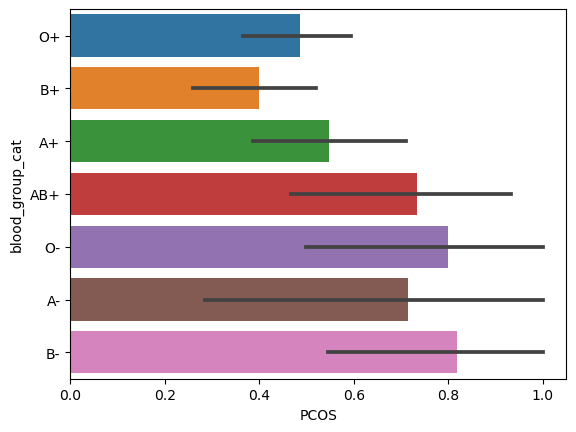

In [1950]:
sns.barplot(x = "PCOS", y = "blood_group_cat", data = sub_pulse)

Consider adding pulse_rate*blood_group_cat

# Logistic Regression

In [964]:
naive = sm.logit("PCOS ~ age + BMI + hw_ratio", data = train).fit()

Optimization terminated successfully.
         Current function value: 0.652615
         Iterations 5


Classification accuracy = 66.9014%
False Negative = 48.1481%
False Positive = 29.5652%


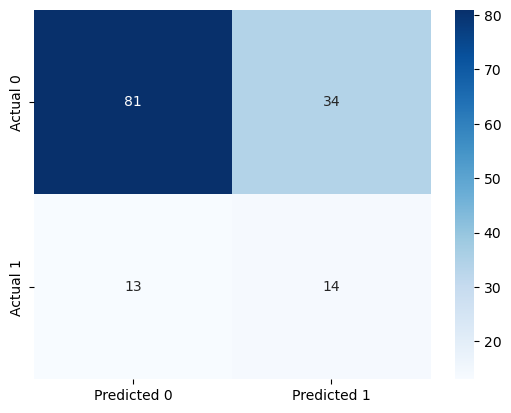

In [965]:
confusion_matrix_test(test, test.PCOS, naive, cutoff = 0.5)

In [966]:
final = sm.logit("PCOS ~ cycle + pregnant*pimples + pregnant + skin_dark +skin_dark*fast_food + pregnant*weight + blood_group_cat*pulse_rate + age + cycle + marriage_years + fast_food + pimples + hair_growth + number_abortions + regular_exercise*fast_food + regular_exercise*cycle + hw_ratio*fast_food + hw_ratio*pimples + BMI*pimples + BMI*regular_exercise + blood_group_cat*age", data = train).fit()
final.summary()


         Current function value: 0.318095
         Iterations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   PCOS   No. Observations:                  486
Model:                          Logit   Df Residuals:                      443
Method:                           MLE   Df Model:                           42
Date:                Thu, 02 Mar 2023   Pseudo R-squ.:                  0.5409
Time:                        22:15:26   Log-Likelihood:                -154.59
converged:                      False   LL-Null:                       -336.77
Covariance Type:            nonrobust   LLR p-value:                 5.718e-53
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            20.4877     16.033      1.278      0.201     -10.937      51.912
blood_group_cat[T.A-]                78.3427    221.542      0.354      0.724    -355.872     512.558
blood_group_cat[T.AB+]              -17.3621     20.730     -0.838      0.402     -57.993      23.268
blood_group_cat[T.AB-]                0.0038        nan        nan        nan         nan         nan
blood_group_cat[T.B+]               -21.8411     17.121     -1.276      0.202     -55.398      11.716
blood_group_cat[T.B-]               128.6836     47.751      2.695      0.007      35.094     222.273
blood_group_cat[T.O+]                -1.1881     16.396     -0.072      0.942     -33.324      30.948
blood_group_cat[T.O-]               -73.3538     25.922     -2.830      0.005    -124.159     -22.548
cycle                                -0.7114      0.128     -5.563      0.000      -0.962      -0.461
pregnant                              1.1138      1.767      0.630      0.528      -2.349       4.577
pimples                             -16.2264      6.663     -2.435      0.015     -29.286      -3.167
pregnant:pimples                      0.2195      0.719      0.305      0.760      -1.189       1.628
skin_dark                             2.6237      0.716      3.662      0.000       1.219       4.028
fast_food                           -14.8676      7.734     -1.922      0.055     -30.026       0.291
skin_dark:fast_food                  -0.1580      0.816     -0.194      0.846      -1.758       1.442
weight                               -0.0573      0.037     -1.535      0.125      -0.131       0.016
pregnant:weight                      -0.0167      0.030     -0.563      0.574      -0.075       0.042
pulse_rate                            0.0713      0.187      0.381      0.703      -0.296       0.438
blood_group_cat[T.A-]:pulse_rate     -1.0635      3.076     -0.346      0.730      -7.093       4.966
blood_group_cat[T.AB+]:pulse_rate     0.1667      0.269      0.621      0.535      -0.360       0.693
blood_group_cat[T.AB-]:pulse_rate     0.2706        nan        nan        nan         nan         nan
blood_group_cat[T.B+]:pulse_rate      0.2101      0.216      0.972      0.331      -0.213       0.634
blood_group_cat[T.B-]:pulse_rate     -1.7956      0.684     -2.627      0.009      -3.135      -0.456
blood_group_cat[T.O+]:pulse_rate     -0.0198      0.208     -0.095      0.924      -0.428       0.388
blood_group_cat[T.O-]:pulse_rate      0.9319      0.345      2.704      0.007       0.257       1.607
age                                  -0.2122      0.125     -1.704      0.088      -0.456       0.032
blood_group_cat[T.A-]:age            -0.0471      0.346     -0.136      0.892      -0.725       0.631
blood_group_cat[T.AB+]:age            0.1849      0.168      1.101      0.271      -0.144       0.514
blood_group_cat[T.AB-]:age            0.1203   1.86e+12   6.45e-14      1.000  

Classification accuracy = 82.3944%
False Negative = 44.4444%
False Positive = 11.3043%


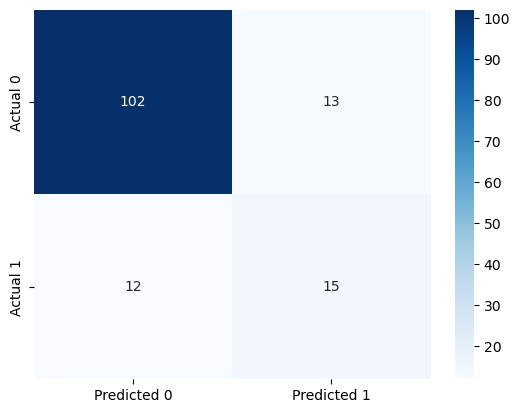

In [967]:
confusion_matrix_test(test, test.PCOS, final, cutoff = 0.5)